# USDA - National Agricultural Statistics Service

### Import Python tools and Jupyter configuration

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import geopandas as gpd
import altair as alt
from datetime import timedelta
import numpy as np

In [3]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = None

In [4]:
src = pd.read_csv(
    "data/raw/lettuce_acres_harvested_states_2017.csv",
    dtype={"County ANSI": "str", "State ANSI": "str"},
)

In [5]:
src.columns = src.columns.str.lower().str.replace(" ", "_", regex=True)

In [6]:
src_slim = src[
    (src["data_item"] == "LETTUCE - ACRES HARVESTED") & (src["domain"] == "TOTAL")
][["year", "geo_level", "state", "state_ansi", "data_item", "value"]]

In [7]:
src_slim.rename(columns={"state_ansi": "state_fips"}, inplace=True)

In [8]:
src_slim["geo_level"] = src_slim["geo_level"].str.title()
src_slim["state"] = src_slim["state"].str.title()
src_slim["data_item"] = src_slim["data_item"].str.title()

In [9]:
src_slim.sort_values("value", ascending=False).head()

,year,geo_level,state,state_fips,data_item,value
498,2017,State,Minnesota,27,Lettuce - Acres Harvested,97
450,2017,State,Maryland,24,Lettuce - Acres Harvested,95
402,2017,State,Kentucky,21,Lettuce - Acres Harvested,93
274,2017,State,Florida,12,Lettuce - Acres Harvested,"9,309"
786,2017,State,South Dakota,46,Lettuce - Acres Harvested,9


### Strip out withheld values

In [10]:
# D = Withheld to avoid disclosing data for individual operations.
# Z = Less than half the rounding unit.

In [11]:
src_slim["value"] = (
    src_slim["value"]
    .str.strip(" ")
    .str.replace("(D)", "0", regex=False)
    .str.replace("(Z)", "0", regex=False)
    .str.replace(",", "", regex=False)
)

In [12]:
src_slim["value"] = src_slim["value"].astype(int)

In [13]:
ap_states = pd.read_csv(
    "https://raw.githubusercontent.com/stiles/notebooks/69e1e55cdff595b10cfa6e8187e1d569cebae2d1/census/raw/ap_states.csv"
)

In [14]:
ap_states.head()

,name,usps,ap
0,Alabama,AL,Ala.
1,Alaska,AK,Alaska
2,Arizona,AZ,Ariz.
3,Arkansas,AR,Ark.
4,California,CA,Calif.


In [15]:
src_slim["ap_state"] = src_slim["state"].map(ap_states.set_index("name")["ap"])

In [16]:
src_slim.head()

,year,geo_level,state,state_fips,data_item,value,ap_state
0,2017,State,Alabama,01,Lettuce - Acres Harvested,19,Ala.
16,2017,State,Alaska,02,Lettuce - Acres Harvested,81,Alaska
43,2017,State,Arizona,04,Lettuce - Acres Harvested,72411,Ariz.
122,2017,State,Arkansas,05,Lettuce - Acres Harvested,30,Ark.
149,2017,State,California,06,Lettuce - Acres Harvested,250157,Calif.


In [17]:
df = src_slim.copy()

---

In [18]:
df.head()

,year,geo_level,state,state_fips,data_item,value,ap_state
0,2017,State,Alabama,01,Lettuce - Acres Harvested,19,Ala.
16,2017,State,Alaska,02,Lettuce - Acres Harvested,81,Alaska
43,2017,State,Arizona,04,Lettuce - Acres Harvested,72411,Ariz.
122,2017,State,Arkansas,05,Lettuce - Acres Harvested,30,Ark.
149,2017,State,California,06,Lettuce - Acres Harvested,250157,Calif.


In [19]:
df.tail()

,year,geo_level,state,state_fips,data_item,value,ap_state
866,2017,State,Virginia,51,Lettuce - Acres Harvested,102,Va.
882,2017,State,Washington,53,Lettuce - Acres Harvested,223,Wash.
898,2017,State,West Virginia,54,Lettuce - Acres Harvested,32,W.Va.
914,2017,State,Wisconsin,55,Lettuce - Acres Harvested,174,Wis.
930,2017,State,Wyoming,56,Lettuce - Acres Harvested,4,Wyo.


In [20]:
df[df["state"] == "California"]

,year,geo_level,state,state_fips,data_item,value,ap_state
149,2017,State,California,06,Lettuce - Acres Harvested,250157,Calif.


In [21]:
df.sort_values("value", ascending=False).head(20)

,year,geo_level,state,state_fips,data_item,value,ap_state
149,2017,State,California,06,Lettuce - Acres Harvested,250157,Calif.
43,2017,State,Arizona,04,Lettuce - Acres Harvested,72411,Ariz.
274,2017,State,Florida,12,Lettuce - Acres Harvested,9309,Fla.
226,2017,State,Colorado,08,Lettuce - Acres Harvested,2397,Colo.
610,2017,State,New Jersey,34,Lettuce - Acres Harvested,1298,N.J.
642,2017,State,New York,36,Lettuce - Acres Harvested,1184,N.Y.
482,2017,State,Michigan,26,Lettuce - Acres Harvested,1027,Mich.
626,2017,State,New Mexico,35,Lettuce - Acres Harvested,829,N.M.
690,2017,State,Ohio,39,Lettuce - Acres Harvested,429,Ohio
722,2017,State,Oregon,41,Lettuce - Acres Harvested,412,Ore.


---

### Read geography file for places

In [22]:
gdf_poly = gpd.read_file(
    "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"
)

### Convert polygons to points

In [23]:
gdf_poly = gdf_poly.to_crs("ESRI:102008")

In [24]:
# gdf_poly["x"] = gdf_poly.centroid.map(lambda p: p.x)
# gdf_poly["y"] = gdf_poly.centroid.map(lambda p: p.y)

In [25]:
gdf_points = gdf_poly.copy()

In [26]:
gdf_points["geometry"] = gdf_points["geometry"].centroid

### Clean up column names

In [27]:
gdf_points.columns = gdf_points.columns.str.lower()

In [28]:
gdf_points.head()

,id,name,density,geometry
0,01,Alabama,94.650,POINT (817707.727 -806908.935)
1,02,Alaska,1.264,POINT (-2731552.814 3579656.886)
2,04,Arizona,57.050,POINT (-1363318.591 -558633.562)
3,05,Arkansas,56.430,POINT (308210.284 -593478.999)
4,06,California,241.700,POINT (-1948054.320 -87693.537)


In [29]:
geodf = gdf_points[["id", "geometry"]].copy()

In [30]:
geodf.head()

,id,geometry
0,01,POINT (817707.727 -806908.935)
1,02,POINT (-2731552.814 3579656.886)
2,04,POINT (-1363318.591 -558633.562)
3,05,POINT (308210.284 -593478.999)
4,06,POINT (-1948054.320 -87693.537)


In [31]:
geo_df = gpd.GeoDataFrame(df.merge(geodf, left_on="state_fips", right_on="id"))

---

### Export

In [32]:
geo_df.to_csv("data/processed/lettuce_acres_harvested_states_2017.csv", index=False)

Unable to revert mtime: /Library/Fonts


<AxesSubplot:>

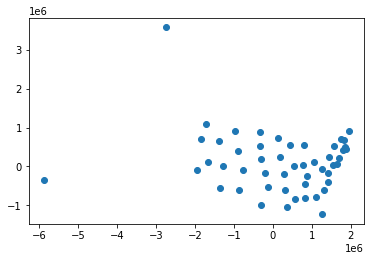

In [33]:
geo_df.plot()

In [34]:
geo_df.to_file(
    "data/processed/lettuce_acres_harvested_states_2017.geojson", driver="GeoJSON"
)